# MBTA Bus Arrival Departure
### Setup
Ensure the packages are installed listed below and ensure departure_arrival folder is created on the same directory as final.ipynb with the csv files taken from "MBTA Bus Arrival Departure Times 20__".

The results are stored in the results folder if you wish to look through that rather than running the notebook.

Ensure "stops.csv" is downloaded from MBTA website for stop latitude and longitude calculations.

In [32]:
import pandas as pd
import glob
from tqdm import tqdm

file_pattern = "departure_arrival/*.csv"
csv_files = sorted(glob.glob(file_pattern))

stops = pd.read_csv("stops.csv")

print(csv_files)

[]


### Data Parsing & Calculation
Data calculations will take around 10 minutes per year. The following was tested on csv's from 2018-2024. The data format may change (such as column name) that may require modifications of parsing. This already happens in 2019 where the column name and encoding changes so adjust accordingly.

Running the blocks below will result in 2 CSV files "final_stop_summary.csv" and "final_route_summary.csv" that will both contain their respective ID, month, total lateness, sample size, and average lateness. "final_stop_summary" also includes coordinates which we can use for ARCGIS later.

In [ ]:
total_lateness_results = []
count_results = []
lateness_over_time = []
timestamps = [] 
chunk_size = 500000
total_lateness = 0
num_rows = 0
for csv_file in csv_files:
    print(f"Processing {csv_file} in chunks...")

    for chunk_idx, chunk in enumerate(tqdm(pd.read_csv(csv_file, chunksize=chunk_size, encoding='utf-8-sig'))):
        chunk.columns = chunk.columns.str.strip().str.replace("\ufeff", "", regex=False).str.lower()

        chunk.columns = [col.lower().replace("servicedate", "service_date") for col in chunk.columns]

        chunk.columns = [col.lower().replace("stop", "stop_id") for col in chunk.columns]

        chunk.columns = [col.lower().replace("route", "route_id") for col in chunk.columns]

        # Convert datetime columns
        chunk["service_date"] = pd.to_datetime(chunk["service_date"], errors="coerce")
        chunk = chunk.dropna(subset=["service_date"])

        chunk["month"] = chunk["service_date"].dt.to_period("M").astype(str)


        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"]).dt.strftime("%H:%M:%S")
        chunk["actual"] = pd.to_datetime(chunk["actual"]).dt.strftime("%H:%M:%S")

        chunk["scheduled"] = pd.to_datetime(chunk["service_date"].dt.date.astype(str) + " " + chunk["scheduled"])
        chunk["actual"] = pd.to_datetime(chunk["service_date"].dt.date.astype(str) + " " + chunk["actual"])

        # We ignore earliness as there is no indication of what it means and how it's calculated 
        # in the source (i.e. being late gives positive earliness scores sometimes but usually negative)
        chunk = chunk.drop(columns=["service_date"])

        # calculate our own lateness score which is just in seconds
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()

        total_lateness_per_route = chunk.groupby(["route_id", "month"], as_index=False)["lateness"].sum()
        total_lateness_results.append(total_lateness_per_route)

        route_counts = chunk.groupby(["route_id", "month"], as_index=False).size()
        count_results.append(route_counts)

        lateness_over_time.extend(chunk["lateness"].values)
        timestamps.extend(chunk["actual"].values)

In [ ]:
final_total_lateness_chunks = pd.concat(total_lateness_results, ignore_index=True)
final_counts_chunks = pd.concat(count_results, ignore_index=True)

final_route_total_lateness = final_total_lateness_chunks.groupby(["route_id", "month"], as_index=False)["lateness"].sum()
final_route_counts = final_counts_chunks.groupby(["route_id", "month"], as_index=False).sum()
final_route_summary = final_route_total_lateness.merge(final_route_counts, on=["route_id", "month"], how="left")
final_route_summary["average_lateness"] = final_route_summary["lateness"] / final_route_summary["size"]

final_route_summary.to_csv("results/final_route_summary.csv", index=False)

final_stop_total_lateness = final_total_lateness_chunks.groupby(["stop_id", "month"], as_index=False)["lateness"].sum()
final_stop_counts = final_counts_chunks.groupby(["stop_id", "month"], as_index=False).sum()
final_stop_summary = final_stop_total_lateness.merge(final_stop_counts, on=["stop_id", "month"], how="left")
final_stop_summary["average_lateness"] = final_stop_summary["lateness"] / final_stop_summary["size"]
stops["stop_id"] = stops["stop_id"].astype(str)
final_stop_summary["stop_id"] = final_stop_summary["stop_id"].astype(str)

final_stop_summary_with_coords = final_stop_summary.merge(
    stops[["stop_id", "stop_lat", "stop_lon"]], 
    on="stop_id", 
    how="left"
)

final_stop_summary_with_coords.to_csv("results/final_stop_summary.csv", index=False)

## Answering Questions
The blocks below aim to answer questions asked by the Spark! project.

- On average, how long does an individual have to wait for a bus (on time vs. delayed)?
- What is the average delay time of all routes across the entire city?
- What is the average delay time of the target bus routes (22, 29, 15, 45, 28, 44, 42, 17, 23, 31, 26, 111, 24, 33, 14 - from Livable Streets report)?
- Can we chart changes over TIME?
- Are there disparities in the service levels of different routes (which lines are late more often than others)?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#### On average, how long does an individual have to wait for a bus (on time vs. delayed)? & What is the average delay time of all routes across the entire city? & What is the average delay time of the target bus routes (22, 29, 15, 45, 28, 44, 42, 17, 23, 31, 26, 111, 24, 33, 14 - from Livable Streets report)?
The first question asks for the average delay time of all stops and the second question asks for the average delay time for all routes. The third question just requires us to look at average delay time for each of these routes. These blocks assume that you either have the final route and summary calculated or downloaded. If the target bus routes are different, modify it in the cell below.

In [ ]:
final_route_summary = pd.read_csv("results/final_route_summary.csv")
final_stop_summary = pd.read_csv("results/final_stop_summary.csv")
target_routes = [22, 29, 15, 45, 28, 44, 42, 17, 23, 31, 26, 111, 24, 33, 14]

# The CSV saved the route_id as strings so need to convert to string for matching
target_routes = [str(r) for r in target_routes]

In [31]:
final_stop_summary["year"] = final_stop_summary["month"].str[:4].astype(int)
final_route_summary["year"] = final_route_summary["month"].str[:4].astype(int)

# Q1: Stop average lateness by year
print("Q1: Stop average lateness by year")
stop_lateness_by_year = (
    final_stop_summary
    .groupby("year")[["lateness", "size"]]
    .apply(lambda df: df["lateness"].sum() / df["size"].sum())
)
for year, avg in stop_lateness_by_year.items():
    print(f"{year}: {avg:.2f}")

# Q2: Route average lateness by year
print("\nQ2: Route average lateness by year")
route_lateness_by_year = (
    final_route_summary
    .groupby("year")[["lateness", "size"]]
    .apply(lambda df: df["lateness"].sum() / df["size"].sum())
)
for year, avg in route_lateness_by_year.items():
    print(f"{year}: {avg:.2f}")

# Q3: Target route average lateness by year
print("\nQ3: Target route average lateness by year")
target_route_lateness_by_year = {}
for route in target_routes:
    route_data = final_route_summary[final_route_summary["route_id"] == route]
    if not route_data.empty:
        yearly_avg = (
            route_data
            .groupby("year")[["average_lateness", "size"]]
            .apply(lambda df: (df["average_lateness"] * df["size"]).sum() / df["size"].sum())
        )
        target_route_lateness_by_year[route] = yearly_avg

        for year, avg in yearly_avg.items():
            print(f"Route {route} ({year}): {avg:.2f}")
    else:
        print(f"Route {route}: No data found")

Q1: Stop average lateness by year
2018: 251.93
2019: 227.15
2020: 55.87
2021: 132.47
2022: 207.42
2023: 246.13
2024: 267.08

Q2: Route average lateness by year
2018: 249.47
2019: 224.46
2020: 53.29
2021: 129.69
2022: 205.49
2023: 243.43
2024: 263.72

Q3: Target route average lateness by year
Route 22 (2018): 281.35
Route 22 (2019): 239.11
Route 22 (2020): 45.13
Route 22 (2021): 86.58
Route 22 (2022): 141.89
Route 22 (2023): 333.69
Route 22 (2024): 381.42
Route 29 (2018): 422.18
Route 29 (2019): 412.75
Route 29 (2020): 203.67
Route 29 (2021): 214.12
Route 29 (2022): 274.37
Route 29 (2023): 499.45
Route 29 (2024): 487.36
Route 15 (2018): 213.60
Route 15 (2019): 215.40
Route 15 (2020): 122.91
Route 15 (2021): 116.68
Route 15 (2022): 131.38
Route 15 (2023): 209.53
Route 15 (2024): 271.07
Route 45 (2018): 233.41
Route 45 (2019): 231.34
Route 45 (2020): 166.09
Route 45 (2021): 132.88
Route 45 (2022): 209.29
Route 45 (2023): 316.55
Route 45 (2024): 361.81
Route 28 (2018): 153.73
Route 28 (201

#### Can we chart changes over TIME?
The blocks below assume you've ran the previous 2 cells.

Although we answered the previous questions, let's plot them on a graph to see any noticable trends.

Stop summary can be seen visually through ArcGIS Online. There are some things to note. Due to the fact that (most likely) the stops.csv doesn't keep track of disbanded stops, certain stops from previous years have no match on the stops.csv. If you wish to graph on ArcGIS, you will need to remove values that have no matches. Use the resulting "arcgis_final_stop_summary.csv" when importing files into arcgis

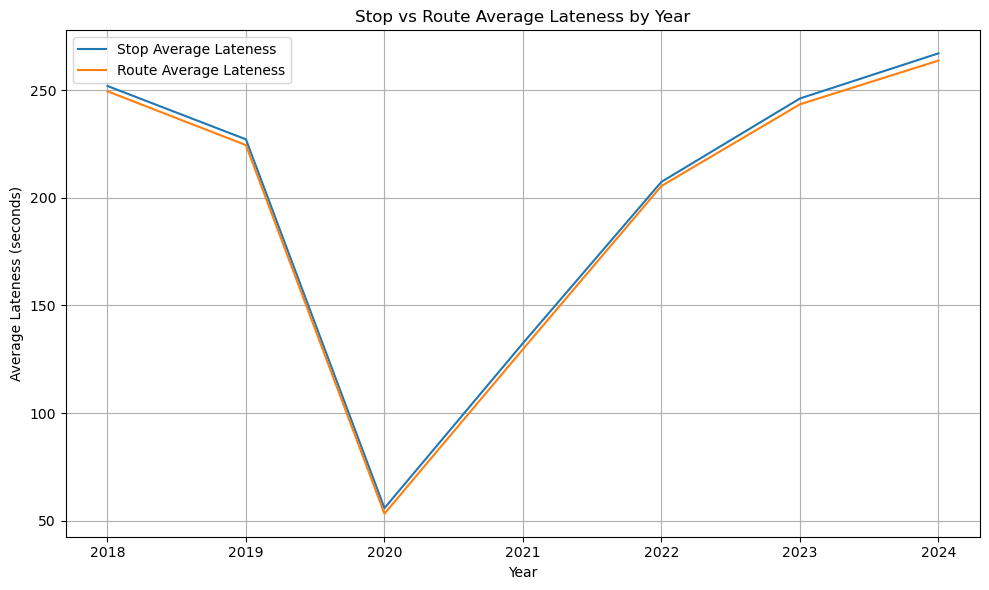

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(stop_lateness_by_year.index, stop_lateness_by_year.values, label="Stop Average Lateness")
plt.plot(route_lateness_by_year.index, route_lateness_by_year.values, label="Route Average Lateness")
plt.xlabel("Year")
plt.ylabel("Average Lateness (seconds)")
plt.title("Stop vs Route Average Lateness by Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

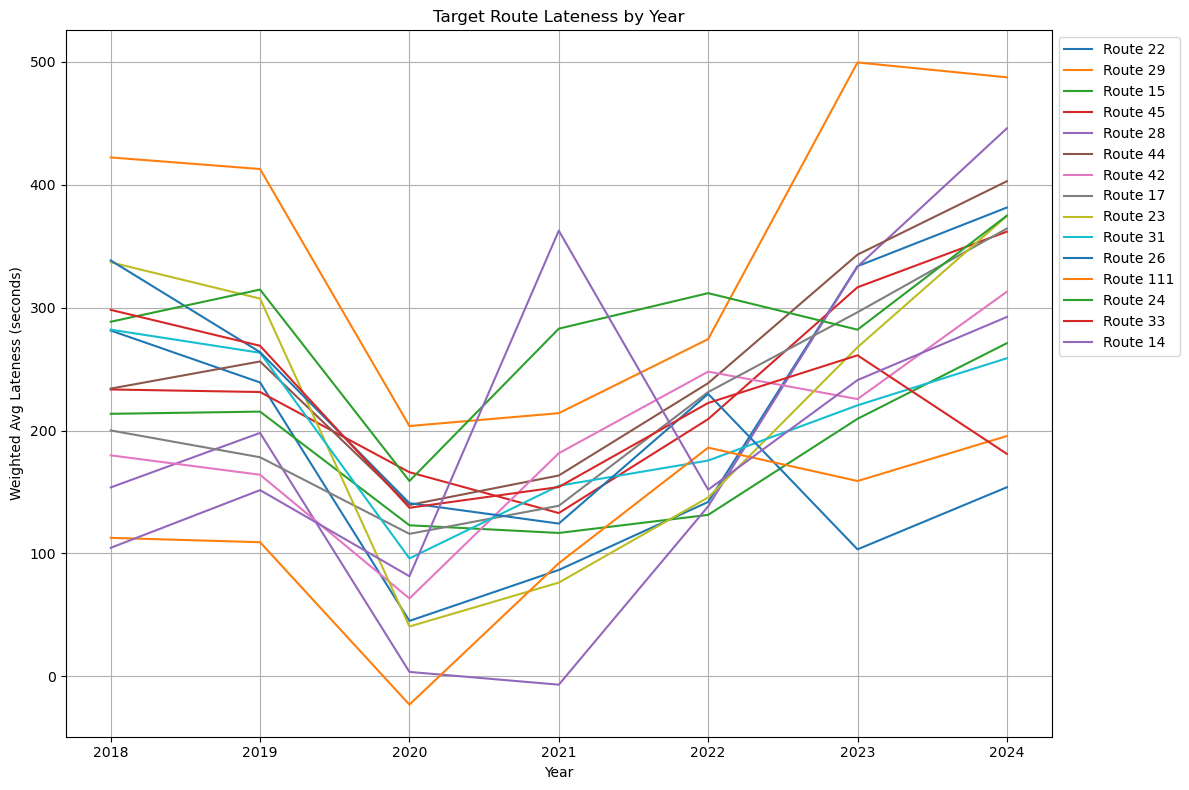

In [25]:
plt.figure(figsize=(12, 8))
for route, series in target_route_lateness_by_year.items():
    plt.plot(series.index, series.values, label=f"Route {route}")

plt.xlabel("Year")
plt.ylabel("Weighted Avg Lateness (seconds)")
plt.title("Target Route Lateness by Year")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
final_stop_summary = pd.read_csv("final_stop_summary.csv")
final_stop_summary.isna().sum()
arcgis_final_stop_summary = final_stop_summary.dropna()

arcgis_final_stop_summary.to_csv("results/arcgis_final_stop_summary.csv", index=False)

### Modeling

The modeling section assumes that you've run the data collection section of the notebook. We use KNN and DBScan and require location positions, so we'll only be runnning on the final_stop_summary.csv. This suffers from the same issue as working with ArcGIS; Certain stops don't have values presumabley because they don't exist anymore. We drop these for code to run.

In [ ]:
import pandas as pd
from collections import defaultdict
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import shutil
import os
from matplotlib.colors import ListedColormap
import glob
from PIL import Image as PILImage
from IPython.display import Image as IPyImage, display
from datetime import datetime

file_path = "results/final_stop_summary.csv"
df = pd.read_csv(file_path)

#### KMeans

In [ ]:
df["year"] = df["month"].str[:4].astype(int)

stop_total_lateness = defaultdict(int)
stop_total_size = defaultdict(int)
stop_lat = {}
stop_long = {}
# Grouping by stop and year to grab mean lateness for a stop given a year
for _, row in df.iterrows():
    key = (row['stop_id'], row['year']) 
    stop_total_lateness[key] += row['lateness']
    stop_total_size[key] += row['size']
    if row['stop_id'] not in stop_lat:
        stop_lat[row['stop_id']] = row['stop_lat']
        stop_long[row['stop_id']] = row['stop_lon']

stop_agg_df = pd.DataFrame({
    "stop_id": [k[0] for k in stop_total_lateness.keys()],
    "year": [k[1] for k in stop_total_lateness.keys()],
    "average_lateness": [
        stop_total_lateness[k] / stop_total_size[k] for k in stop_total_lateness.keys()
    ],
    "stop_lat": [stop_lat[k[0]] for k in stop_total_lateness.keys()],
    "stop_lon": [stop_long[k[0]] for k in stop_total_lateness.keys()]
})

stop_agg_df = stop_agg_df.sort_values(by=["stop_id", "year"]).reset_index(drop=True)
stop_agg_df = stop_agg_df.dropna(subset=["stop_lat", "stop_lon"])

# Scaling to ensure lat & lon is considered
X_original = stop_agg_df[["stop_lat", "stop_lon", "average_lateness"]].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)


Here we see which K values yield best results. Which just like running it with one year from the midterm report, is still 7.

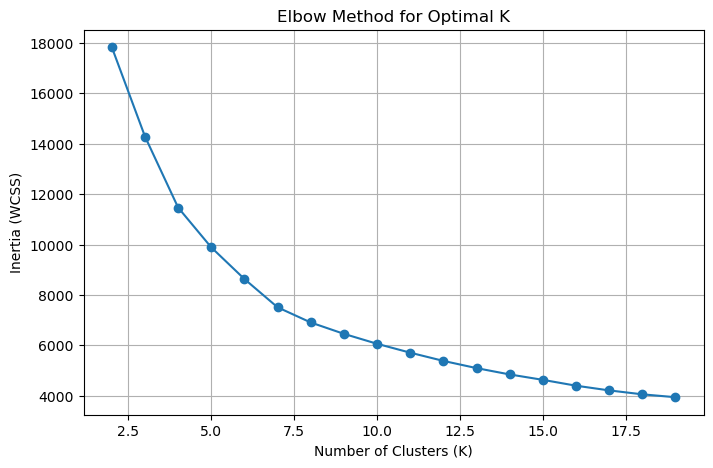

In [42]:
inertia = []
K_range = range(2, 20) 

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

GIF created with PIL: kmeans_max_lateness_clusters.gif
Cleaned up: kmeans_frames/ folder deleted.


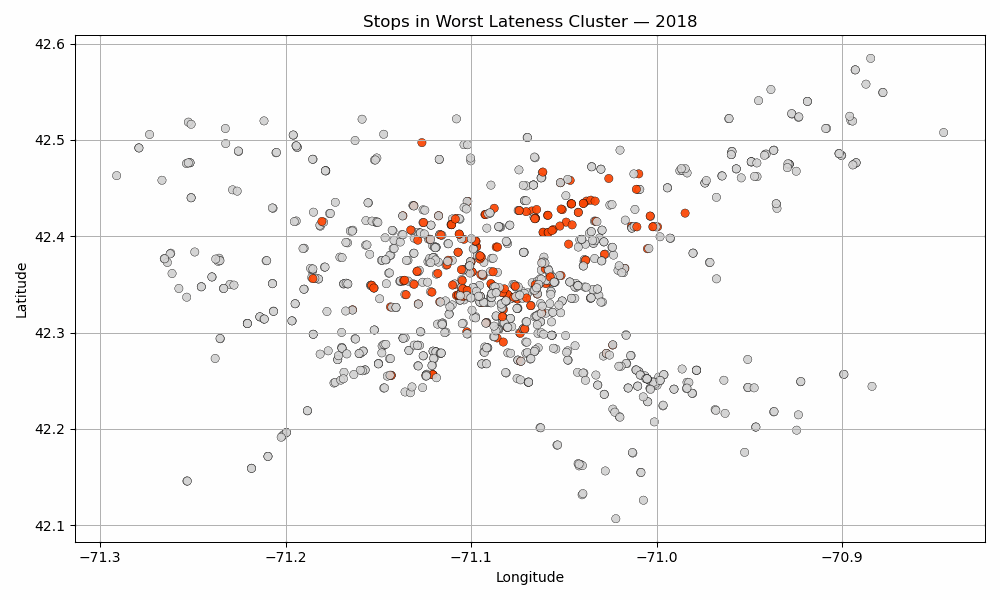

In [71]:
os.makedirs("kmeans_frames", exist_ok=True)

cmap = ListedColormap(["lightgray", "orangered"])

years = sorted(stop_agg_df["year"].unique())

for year in years:
    yearly_df = stop_agg_df[stop_agg_df["year"] == year].dropna()

    if len(yearly_df) < 7:
        continue

    X = yearly_df[["stop_lat", "stop_lon", "average_lateness"]].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    optimal_k = 7
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    yearly_df = yearly_df.copy()
    yearly_df["cluster"] = clusters

    cluster_avg = yearly_df.groupby("cluster")["average_lateness"].mean()
    worst_cluster = cluster_avg.idxmax()

    color_labels = (yearly_df["cluster"] == worst_cluster).astype(int)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        yearly_df["stop_lon"],
        yearly_df["stop_lat"],
        c=color_labels,
        cmap=cmap,
        edgecolor="k",
        linewidth=0.3,
        alpha=0.9
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Stops in Worst Lateness Cluster — {year}")
    plt.grid(True)
    plt.tight_layout()

    frame_path = f"kmeans_frames/clustering_{year}.png"
    plt.savefig(frame_path)
    plt.close()


frame_paths = sorted(glob.glob("kmeans_frames/clustering_*.png"))

frames = [PILImage.open(fp) for fp in frame_paths]

if frames:
    frames[0].save(
        "kmeans_max_lateness_clusters.gif",
        save_all=True,
        append_images=frames[1:],
        duration=1500,
        loop=0
    )
    print("GIF created with PIL: kmeans_max_lateness_clusters.gif")

shutil.rmtree("kmeans_frames", ignore_errors=True)
print("Cleaned up: kmeans_frames/ folder deleted.")

display(IPyImage(filename="kmeans_max_lateness_clusters.gif"))

In [77]:
worst_cluster_points = []

for year in years:
    yearly_df = stop_agg_df[stop_agg_df["year"] == year].dropna()

    if len(yearly_df) < 7:
        continue

    X = yearly_df[["stop_lat", "stop_lon", "average_lateness"]].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    yearly_df = yearly_df.copy()
    yearly_df["cluster"] = clusters

    cluster_avg = yearly_df.groupby("cluster")["average_lateness"].mean()
    worst_cluster = cluster_avg.idxmax()

    worst_points = yearly_df[yearly_df["cluster"] == worst_cluster].copy()
    worst_points["year"] = year
    worst_cluster_points.append(worst_points)


combined_df = pd.concat(worst_cluster_points, ignore_index=True)
combined_df["date"] = combined_df["year"].apply(lambda y: datetime.strptime(f"{y}-01-01", "%Y-%m-%d"))
combined_df.to_csv("results/kmeans_worst_cluster_by_year.csv", index=False)
print("Exported: kmeans_worst_cluster_by_year.csv")

combined_df

Exported: worst_clusters_by_year.csv


,stop_id,year,average_lateness,stop_lat,stop_lon,cluster,date
0,7,2018,341.576763,42.333043,-71.081108,5,2018-01-01
1,77,2018,428.003614,42.349950,-71.089148,5,2018-01-01
2,82,2018,481.588065,42.342478,-71.084701,5,2018-01-01
3,84,2018,474.988074,42.339074,-71.080299,5,2018-01-01
4,87,2018,349.595591,42.339459,-71.080362,5,2018-01-01
...,...,...,...,...,...,...,...
1271,41391,2024,405.830638,42.340553,-71.088908,0,2024-01-01
1272,71855,2024,386.975810,42.348245,-71.076218,0,2024-01-01
1273,77777,2024,393.888189,42.332906,-71.081253,0,2024-01-01
1274,91391,2024,403.341574,42.336067,-71.100187,0,2024-01-01


#### DBScan

GIF created: dbscan_max_lateness_clusters.gif
Exported: worst_dbscan_clusters_by_year.csv
Cleaned up: dbscan_frames/ folder deleted.


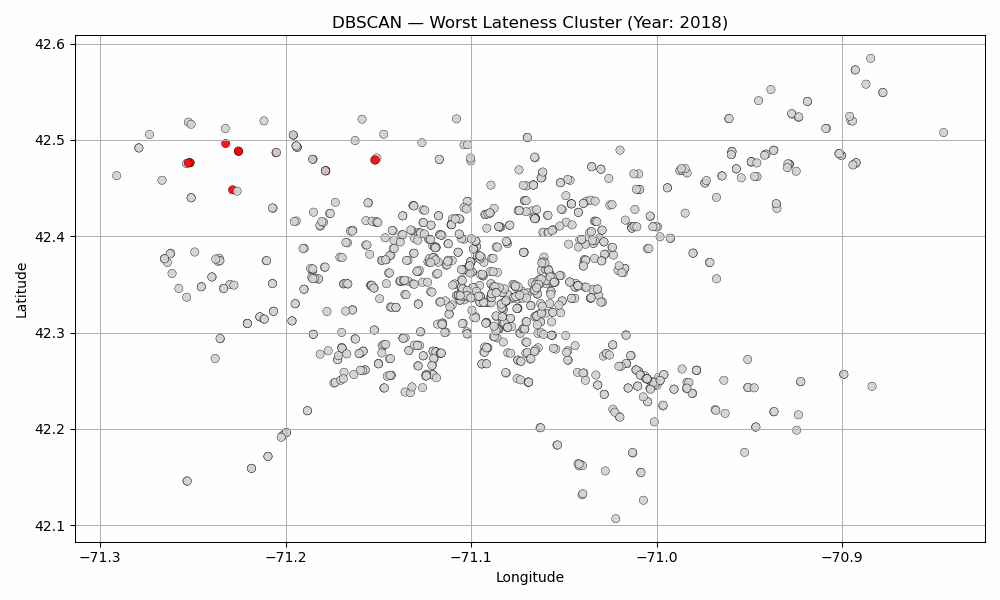

In [96]:
import os
import shutil
import imageio
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from datetime import datetime

os.makedirs("dbscan_frames", exist_ok=True)

worst_cluster_points = []
custom_cmap = ListedColormap(["lightgray", "red"])


for year in sorted(stop_agg_df["year"].unique()):
    yearly_df = stop_agg_df[stop_agg_df["year"] == year].dropna()

    if len(yearly_df) < 5:
        continue

    X = yearly_df[["stop_lat", "stop_lon", "average_lateness"]].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    db = DBSCAN(eps=0.48, min_samples=5)
    clusters = db.fit_predict(X_scaled)
    yearly_df = yearly_df.copy()
    yearly_df["cluster"] = clusters

    valid_clusters = yearly_df[yearly_df["cluster"] != -1]
    if valid_clusters.empty:
        continue

    cluster_avg = valid_clusters.groupby("cluster")["average_lateness"].mean()
    worst_cluster = cluster_avg.idxmax()

    yearly_df["highlight"] = (yearly_df["cluster"] == worst_cluster).astype(int)

    worst_points = yearly_df[yearly_df["highlight"] == 1].copy()
    worst_points["year"] = year
    worst_points["date"] = datetime.strptime(f"{year}-01-01", "%Y-%m-%d")
    worst_cluster_points.append(worst_points)

    plt.figure(figsize=(10, 6))
    plt.scatter(
        yearly_df["stop_lon"],
        yearly_df["stop_lat"],
        c=yearly_df["highlight"],
        cmap=custom_cmap,
        alpha=0.9,
        edgecolor="k",
        linewidth=0.3
    )
    plt.title(f"DBSCAN — Worst Lateness Cluster (Year: {year})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.tight_layout()

    frame_path = f"dbscan_frames/dbscan_{year}.png"
    plt.savefig(frame_path)
    plt.close()

frame_paths = sorted([f for f in os.listdir("dbscan_frames") if f.endswith(".png")])
frames = [PILImage.open(f"dbscan_frames/{fp}") for fp in frame_paths]

if frames:
    frames[0].save(
        "dbscan_max_lateness_clusters.gif",
        save_all=True,
        append_images=frames[1:],
        duration=1500,  
        loop=0
    )
    print("GIF created: dbscan_max_lateness_clusters.gif")

if worst_cluster_points:
    combined_df = pd.concat(worst_cluster_points, ignore_index=True)
    combined_df.to_csv("worst_dbscan_clusters_by_year.csv", index=False)
    print("Exported: worst_dbscan_clusters_by_year.csv")

shutil.rmtree("dbscan_frames", ignore_errors=True)
print("Cleaned up: dbscan_frames/ folder deleted.")

display(IPyImage(filename="dbscan_max_lateness_clusters.gif"))


The results regarding DBScan were too suboptimal (even using previous values) that I didn't end up putting it on ArcGIS.

ArcGIS Results:

Stop Lateness 2018 - 2024 & Outliers

https://bucas.maps.arcgis.com/apps/mapviewer/index.html?webmap=bf72597e2856402d934fe400e54f2869

Click on layers to see which dataset you want to see. Set interval to 11 months on the time slider for worst clusters to see the KMeans outlier clusters, and use 2 month slider for final to see the lateness trend change each month

### Conclusion

The conclusion is stated in the readme (our final report), refer to there for more indepth analysis of data and results of modeling